<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/part-2/Neural_network_face_classificaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Часть 2**
***Решение задачи классификации с использованием нейронных сетей.***

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from google.colab import drive
from sklearn.externals import joblib 
from PIL import Image, ImageDraw

# подключение гугл-диска
drive.mount('/content/drive')

PATH = '/content/drive/My Drive/Курсач/files/'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at /content/drive


In [140]:
#Загрузим всё необходимое

all_features = joblib.load(os.path.join(PATH,'all_features.pkl'))
y_train = joblib.load(os.path.join(PATH,'y_train.pkl'))
y_test = joblib.load(os.path.join(PATH,'y_test.pkl'))
time_of_features_creat = joblib.load(os.path.join(PATH,'time_of_features_creat.pkl'))

features_list = ['Haars features', 'Matrix features','Matrix + PCA features']
categories = ['hf_train', 'mf_train','pca_train', 'hf_test', 'mf_test', 'pca_test']
net_cols = ['neural_net_cpu', 'neural_net_gpu']

#Полносвязная нейронная сеть

Во 2 части предметом исследования станут нейронные сети. А именно мы хотим провести сравнительный анализ для методов машинного обучения и нейронных сетей в задаче классификации лиц на изображении. Для этого возьмём все типы признаков из предыдущей части, а критериями сравнения станут точность, время обучения и предсказания, а также объём занимаемой памяти обученных моделей.

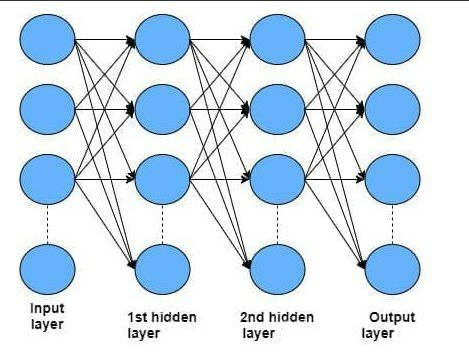  

Для построения архитектуры сети, нам необходимо определить количество слоёв и нейронов, а также задать функцию потерь, оптимизационную функцию и тд... Подбор параметров осуществим эмпирическим путём.  
  
   
**P.S. Построенную полносвязную сеть будем описывать как `a / x_1 / ... / x_n / b`, где `a`, `b` - число нейронов входного слоя и выходного слоя, а `x_i` - число нейронов скрытых слоёв. Результаты экспериментов при построении архитектур можно найти здесь: https://docs.google.com/spreadsheets/d/1Qvn6k-yyfEuRum9eUxRetVPQpU6imFPau3qaQrLEOYc/edit?usp=sharing**



#Блок для "потыкать"
Данная часть является временной и нужна лишь для чуть более удобной возможности "шевелить" параметры сети :)

In [6]:
#временный блок для удобства перебора параметров
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


def architecture(x_train, x_test, y_train, y_test, is_gpu, loop, input):

    x_train_torch = torch.from_numpy(x_train).float()
    x_test_torch = torch.from_numpy(x_test).float()
    y_train_torch = torch.from_numpy(y_train)
    y_test_torch = torch.from_numpy(y_test)

    class Net(nn.Module):
      def __init__(self, input_len):
           super(Net, self).__init__()
           self.fc1 = nn.Linear(input_len, 70)
           self.fc2 = nn.Linear(70, 35)
           self.fc3 = nn.Linear(35, 2)

      def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.sigmoid(self.fc3(x))
            return x


    net = Net(input)

    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    if is_gpu == 1:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        net.to(device)
        x_train_torch, y_train_torch = x_train_torch.to(device), y_train_torch.to(device)
        print(device)


    for epoch in range(loop): # loop

        optimizer.zero_grad()
        output = net(x_train_torch)
 
        loss = criterion(output, y_train_torch)
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0 or epoch == loop - 1:
            print('Epoch: ', epoch, 'Loss: ', loss.item())


#def architecture(x_train, x_test, y_train, y_test, is_normalized,
#                is_gpu, loss_fun, optim, loop, eps, loss_eps):

t0 = time.time()
architecture(all_features[0], all_features[3], y_train, y_test, 1, 1000, 109)
t1 = time.time()
print('Time: ', t1-t0)

cuda:0
Epoch:  0 Loss:  0.691622793674469


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  999 Loss:  0.4238387942314148
Time:  4.18339991569519


In [7]:
# + torch.optim.optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
# + torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# + torch.optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
# + torch.optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
# + torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

#Основная часть
Проведём эксперименты для сети со следующими параметрами:



> Схема сети: len(features)/70/35/2   
  Центрирование признаков: да  
> Функция активации: sigmoid  
> Функция потерь:  CrossEntropyLoss




In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.optim as optim
import time

net_time_df = pd.DataFrame(index = categories, columns = net_cols)
net_accuracy = pd.DataFrame(features_list, index=['1', '2', '3'], columns=['features'])

In [109]:
class Net(nn.Module):
    def __init__(self, input_len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_len, 70)
        self.fc2 = nn.Linear(70, 35)
        self.fc3 = nn.Linear(35, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [133]:
def plot_graphic(y_points, title):
    x_points = lambda x: np.arange(0,len(y_points[x]))

    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=18, fontname='Times New Roman')
    plt.xlabel('Epoch',fontsize=16, fontname='Times New Roman')
    plt.ylabel('Score',fontsize=16, fontname='Times New Roman')
    plt.plot(x_points(0), y_points[0], color='#fb607f', linestyle='-')
    plt.plot(x_points(1), y_points[1], color='#906bff', linestyle='-')
    plt.plot(x_points(2), y_points[2], color='#c71585', linestyle='-')
    plt.legend(features_list, loc='center', shadow=True,fontsize=18)
    plt.show()


In [148]:
def nn_training(x_train, y_train, is_gpu, loop, time_df, feature_type, index, y_points_acc, y_points_loss):
    
    net = Net(len(x_train[0]))
    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    #сделаем массивы точек для построения гафиков accuracy при обучении
    y_points_for_one = []
    y_loss_points_for_one = []

    t0 = time.time()
    x_train_torch = torch.from_numpy(x_train).float()
    y_train_torch = torch.from_numpy(y_train)

    #будем проверять на 2-х процессорах
    if is_gpu == 1:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
    net.to(device)
    x_train_torch, y_train_torch = x_train_torch.to(device), y_train_torch.to(device)
    print(device)

    for epoch in range(loop): # loop

        optimizer.zero_grad()
        output = net(x_train_torch)
        loss = criterion(output, y_train_torch)
        loss.backward()
        optimizer.step()


        y_loss_points_for_one.append(loss.item())
        y_points_for_one.append(accuracy_score(y_train, torch.argmax(output.data, dim = 1 ).cpu()))
        if len(y_points_for_one) >=100 and np.all(y_points_for_one[-100:] == y_points_for_one[-1]):
            print('Train is stopped, no changes in last 100 epoch! Epoch: ', epoch)
            break
    t = time.time()
    print('Last accuracy: ', y_points_for_one[-1])

    #сохраним обученную сеть        
    torch.save(net.state_dict(), os.path.join(PATH, 'Networks', feature_type + '_neural_net.pth'))

    #заполним табличку с временем
    time_df.loc[categories[index]][net_cols[is_gpu]] = (t - t0)

    #нарисуем график 
    if (is_gpu == 1):
        y_points_acc.append(y_points_for_one)
        y_points_loss.append(y_loss_points_for_one)
        if (len(y_points_acc) == 3):
            plot_graphic(y_points_acc, 'Accuracy score')
            plot_graphic(y_points_loss, 'Loss')

In [149]:
def nn_test(x_test, is_gpu, feature_type, data_df, time_df, index):

    #загружаем обученную нейронку
    net = Net(len(x_test[0]))
    net.load_state_dict(torch.load(os.path.join(PATH, 'Networks', feature_type + '_neural_net.pth')))

    t0 = time.time()
    x_test_torch = torch.from_numpy(x_test).float()

    with torch.no_grad():
        output = net(x_test_torch)
        data_df[net_cols[is_gpu]] = torch.argmax(output.data, dim = 1)
    t = time.time()

    time_df.loc[categories[index]][net_cols[is_gpu]] = (t - t0)/len(x_test)

#Примечание
Поскольку время на формирование признаков Хоара и матричных признаков достоточно мало, то в данном блоке мы их учитывать не будем.

cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train is stopped, no changes in last 100 epoch! Epoch:  3484
Last accuracy:  0.9029455393091756
cuda:0
Train is stopped, no changes in last 100 epoch! Epoch:  4721
Last accuracy:  0.9158896658896659
cuda:0
Train is stopped, no changes in last 100 epoch! Epoch:  2715
Last accuracy:  0.9385286430740977


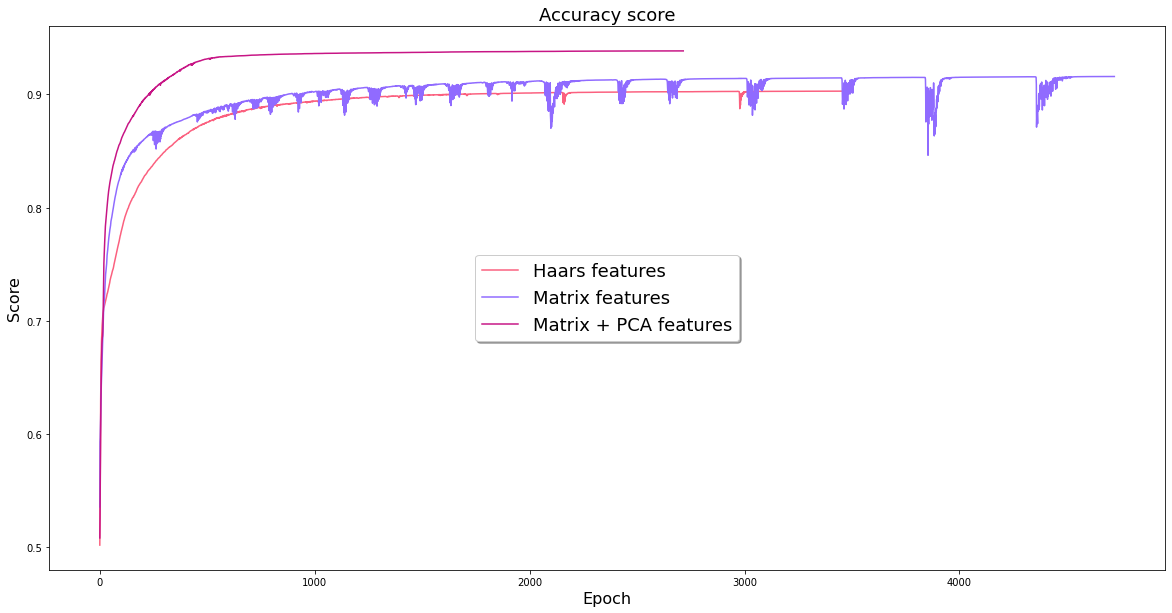

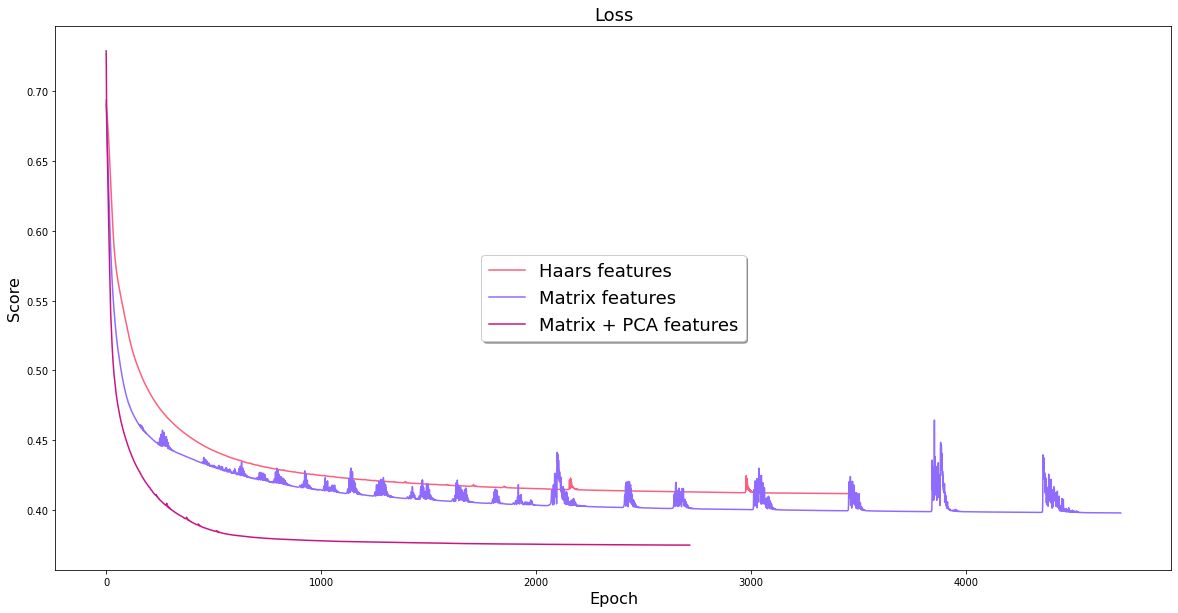

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [150]:
haars_net_df = pd.DataFrame(columns=net_cols)
matrix_net_df = pd.DataFrame(columns=net_cols)
matrix_net_pca_df = pd.DataFrame(columns=net_cols)
y_points_acc = []
y_points_loss = []

MAX_ITER = 50000

for is_gpu in range(1,2):
    nn_training(all_features[0], y_train, is_gpu, MAX_ITER, net_time_df, 'hf', 0, y_points_acc, y_points_loss)
    nn_test(all_features[3], is_gpu, 'hf', haars_net_df, net_time_df, 3)

    nn_training(all_features[1], y_train, is_gpu, MAX_ITER, net_time_df, 'mf', 1, y_points_acc, y_points_loss)
    nn_test(all_features[4], is_gpu, 'mf', matrix_net_df, net_time_df, 4) 

    nn_training(all_features[2], y_train, is_gpu, MAX_ITER, net_time_df, 'mf_pca', 2, y_points_acc, y_points_loss)
    nn_test(all_features[5], is_gpu, 'mf_pca', matrix_net_pca_df, net_time_df, 5)
    
haars_net_df.insert(0, 'y_test', y_test)
matrix_net_df.insert(0, 'y_test', y_test)
matrix_net_pca_df.insert(0, 'y_test', y_test)


In [151]:
haars_net_df[:]

,y_test,neural_net_cpu,neural_net_gpu
0,1,NaN,1
1,0,NaN,0
2,0,NaN,0
3,0,NaN,0
4,0,NaN,1
...,...,...,...
18871,1,NaN,1
18872,0,NaN,0
18873,1,NaN,0
18874,0,NaN,0


In [152]:
net_time_df[:]

,neural_net_cpu,neural_net_gpu
hf_train,NaN,30.9948
mf_train,NaN,52.8899
pca_train,NaN,24.2735
hf_test,NaN,2.33474e-06
mf_test,NaN,4.34192e-06
pca_test,NaN,2.53621e-06


In [153]:
#coxpaним датафреймы
haars_net_df.to_csv(os.path.join(PATH, 'Dataframes', 'haars_net_df.csv'))
matrix_net_df.to_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_df.csv'))
matrix_net_pca_df.to_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_pca_df.csv'))
#net_time_df.to_csv(os.path.join(PATH, 'Dataframes', 'net_time_df.csv'))

In [154]:
from pandas import read_csv

haars_net_df = read_csv(os.path.join(PATH, 'Dataframes', 'haars_net_df.csv')) 
matrix_net_df = read_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_df.csv')) 
matrix_net_pca_df = read_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_pca_df.csv')) 
net_time_df = read_csv(os.path.join(PATH, 'Dataframes', 'net_time_df.csv')) 


net_accuracy['neural_net_gpu'] = [accuracy_score(haars_net_df['y_test'], haars_net_df['neural_net_gpu']),
                                  accuracy_score(matrix_net_df['y_test'], matrix_net_df['neural_net_gpu']),
                                  accuracy_score(matrix_net_pca_df['y_test'], matrix_net_pca_df['neural_net_gpu'])]

net_accuracy[:]

,features,neural_net_gpu
1,Haars features,0.820937
2,Matrix features,0.832009
3,Matrix + PCA features,0.817811
